In [11]:
!pip install pycocoevalcap
!pip install wordfreq

In [12]:
import torch
import gc

gc.collect()                      # gom rác Python
torch.cuda.empty_cache()          # trả lại VRAM chưa dùng cho driver
torch.cuda.ipc_collect()          # dọn shared memory CUDA (nếu có)
!nvidia-smi


Mon Dec 15 13:41:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:

import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import models, transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import math
import re
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [14]:
class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        tokens = text.lower().strip().split()
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        return " ".join(toks)


def collect_rsicd_words(hf_train, hf_val, hf_test, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val, hf_test]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    cnt.update(c.lower().strip().split())
            else:
                cnt.update(cap.lower().strip().split())
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words


# Load dataset
ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], ds["test"], min_freq=3)
print(f"RSICD unique words (freq >=3): {len(rsicd_words)}")

try:
    from wordfreq import top_n_list
    gigaword_top = top_n_list("en", n=5000)
    merged = list(dict.fromkeys(rsicd_words + gigaword_top))
    print(f"After adding wordfreq top-5k: {len(merged)}")
except:
    print("Wordfreq not available, using RSICD only")
    merged = rsicd_words

tokenizer = SimpleTokenizer(merged)
print(f"Final vocab size: {len(tokenizer.stoi)}")

RSICD unique words (freq >=3): 2215
After adding wordfreq top-5k: 6332
Final vocab size: 6336


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=25, is_train=True, n_caps=5):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train
        self.n_caps = n_caps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        # image
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))
        if self.transform is not None:
            image = self.transform(image)

        # captions: lấy đúng 5
        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        caps = caps[:self.n_caps]
        assert len(caps) == self.n_caps

        return image, caps


def collate_fn(batch):
    images_expanded = []
    captions_ids = []
    all_caps_batch = []   # lưu 5 caption gốc/ảnh để SCST + eval

    for image, caps in batch:      # caps: list 5 câu
        all_caps_batch.append(caps)

        for c in caps:             # multi-caption unroll B*5
            images_expanded.append(image)

            ids = tokenizer.encode(c)
            ids = [tokenizer.bos_id] + ids + [tokenizer.eos_id]
            ids = ids[:max_len]
            pad_len = max_len - len(ids)
            if pad_len > 0:
                ids = ids + [tokenizer.pad_id] * pad_len
            captions_ids.append(torch.tensor(ids, dtype=torch.long))

    images_expanded = torch.stack(images_expanded, dim=0)   # [B*5, 3, H, W]
    captions_ids = torch.stack(captions_ids, dim=0)         # [B*5, max_len]

    return images_expanded, captions_ids, all_caps_batch



In [16]:
batch_size = 32
max_len = 25
n_caps = 5

train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform,
                          max_len=max_len, is_train=True, n_caps=n_caps)
val_data   = RSICDDataset(ds["valid"], tokenizer, transform=val_transform,
                          max_len=max_len, is_train=False, n_caps=n_caps)
test_data  = RSICDDataset(ds["test"],  tokenizer, transform=val_transform,
                          max_len=max_len, is_train=False, n_caps=n_caps)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 8734, Val: 1094, Test: 1093


In [17]:
class ViTEncoder(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224.mae",
        output_dim=512,
        dropout_p=0.1,
        n_finetune_blocks=4,     # số block cuối cho phép học
        use_task_cls=True        # dùng CLS riêng cho task captioning
    ):
        super().__init__()
        vit = timm.create_model(model_name, pretrained=True)
        vit.head = nn.Identity()
        self.vit = vit
        vit_dim = vit.num_features

        # 1) Freeze toàn bộ, rồi mở vài block cuối + layer norm
        for p in self.vit.parameters():
            p.requires_grad = False
        if n_finetune_blocks > 0:
            for blk in self.vit.blocks[-n_finetune_blocks:]:
                for p in blk.parameters():
                    p.requires_grad = True
        for p in self.vit.norm.parameters():
            p.requires_grad = True

        # 2) Optional CLS riêng cho task
        self.use_task_cls = use_task_cls
        if use_task_cls:
            self.task_cls = nn.Parameter(torch.zeros(1, 1, vit_dim))
            nn.init.trunc_normal_(self.task_cls, std=0.02)

        # 3) MLP head để đưa về không gian chung với decoder
        self.proj = nn.Sequential(
            nn.Linear(vit_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.GELU(),
            nn.Dropout(dropout_p)
        )

    def forward(self, x):
        """
        x: (B, C, H, W)
        return:
          spatial_feats: (B, N, D) - patch tokens đã project
          global_feats : (B, D)    - CLS cho decoder
        """
        B = x.size(0)

        # ViT timm: forward_features trả (B, N, C) gồm CLS + patch
        feats = self.vit.forward_features(x)          # (B, N, vit_dim)

        if self.use_task_cls:
            # Thay CLS mặc định bằng CLS riêng cho task
            cls_token = self.task_cls.expand(B, -1, -1)   # (B, 1, vit_dim)
            patch_tokens = feats[:, 1:, :]                # (B, N-1, vit_dim)
            feats = torch.cat([cls_token, patch_tokens], dim=1)  # (B, N, vit_dim)

        feats = self.proj(feats)                     # (B, N, output_dim)

        global_feats = feats[:, 0]                   # CLS
        spatial_feats = feats[:, 1:]                 # patch tokens

        return spatial_feats, global_feats

In [18]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=512,
        nhead=8,
        num_layers=4,
        dim_feedforward=2048,
        dropout=0.1,
        pad_idx=0,
        max_len=128
    ):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.max_len = max_len

        # Token embedding + scale
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embed = nn.Embedding(max_len, d_model)

        # Pre-norm decoder layer (ổn định hơn)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # LayerNorm cuối giúp ổn định trước khi lên vocab
        self.out_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, vocab_size)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.fc.weight, mean=0.0, std=0.02)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def _build_causal_mask(self, T, device):
        # mask[i, j] = -inf nếu j > i (không nhìn tương lai)
        mask = torch.full((T, T), float("-inf"), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, spatial_feats, global_feats, caption_ids, enc_padding_mask=None):
        """
        spatial_feats: (B, N, D)
        global_feats : (B, D)
        caption_ids  : (B, T)
        enc_padding_mask: (B, 1+N) nếu có padding trong encoder (optional)
        """
        B, T = caption_ids.size()
        device = caption_ids.device

        # Embedding + pos
        tok_emb = self.embed(caption_ids) * (self.d_model ** 0.5)   # (B, T, D)
        pos = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        pos_emb = self.pos_embed(pos)
        tgt = tok_emb + pos_emb                                     # (B, T, D)
        tgt = self.dropout(tgt)

        # Encoder memory: CLS + patch
        memory = torch.cat([global_feats.unsqueeze(1), spatial_feats], dim=1)  # (B, 1+N, D)

        # Masks
        tgt_mask = self._build_causal_mask(T, device)              # (T, T)
        tgt_key_padding_mask = caption_ids.eq(self.pad_idx)        # (B, T)

        # enc_padding_mask nếu có: (B, 1+N) True ở chỗ padding
        memory_key_padding_mask = enc_padding_mask

        out = self.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        out = self.out_norm(out)
        logits = self.fc(out)                                      # (B, T, vocab)
        return logits


In [43]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        spatial_feats, global_feats = self.encoder(images)
        logits = self.decoder(spatial_feats, global_feats, caption_ids[:, :-1])
        return logits

    def sample_caption_transformer(
        self,
        images,
        tokenizer,
        max_len=25,
        sample=True
    ):
        """
        images: (B, C, H, W)
        return:
          seqs: (B, T)  - token ids
          log_probs: (B, T-1) - log p(token_t | <bos>..token_{t-1})
        """
        device = images.device
        spatial_feats, global_feats = self.encoder(images)      # (B, N, D), (B, D)
    
        B = images.size(0)
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        pad_id = tokenizer.pad_id
    
        seqs = torch.full((B, 1), bos_id, dtype=torch.long, device=device)
        log_probs = []
    
        for t in range(1, max_len):
            logits = self.decoder(spatial_feats, global_feats, seqs)    # (B, t, vocab)
            step_logits = logits[:, -1, :]                              # (B, vocab)
            step_log_probs = step_logits.log_softmax(dim=-1)
    
            if sample:
                probs = step_log_probs.exp()
                next_tokens = torch.multinomial(probs, num_samples=1)   # (B, 1)
            else:
                next_tokens = step_log_probs.argmax(dim=-1, keepdim=True)
    
            seqs = torch.cat([seqs, next_tokens], dim=1)                # (B, t+1)
            log_probs.append(
                step_log_probs.gather(1, next_tokens).squeeze(1)
            )                                                           # (B,)
    
        log_probs = torch.stack(log_probs, dim=1)                       # (B, T-1)
        return seqs, log_probs

    def generate_caption_bleu4(
        self,
        image,
        tokenizer,
        max_len=25,
        beam_size=5,
        alpha=0.7,
        device="cuda"
    ):
        self.eval()
    
        if image.dim() == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
    
        spatial_feats, global_feats = self.encoder(image)
    
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        pad_id = tokenizer.pad_id
        vocab_size = self.decoder.vocab_size
    
        seqs = torch.full((beam_size, 1), bos_id, dtype=torch.long, device=device)
        log_probs = torch.zeros(beam_size, device=device)
        finished = torch.zeros(beam_size, dtype=torch.bool, device=device)
    
        spatial_feats = spatial_feats.expand(beam_size, -1, -1)
        global_feats = global_feats.expand(beam_size, -1)
    
        for t in range(1, max_len + 1):
            if finished.all():
                break
    
            logits = self.decoder(spatial_feats, global_feats, seqs)
            step_logits = logits[:, -1, :]
            step_log_probs = F.log_softmax(step_logits, dim=-1)
    
            step_log_probs[:, pad_id] = -1e9
            total_log_probs = log_probs.unsqueeze(1) + step_log_probs   # (B, vocab)
    
            # ==== PHẦN MASK ĐÃ SỬA ====
            # beam đã kết thúc: chỉ giữ log_prob tại EOS, cấm token khác
            if finished.any():
                # đặt -inf cho tất cả token của những beam đã kết thúc
                total_log_probs[finished] = -1e9
                # gán lại log_prob tại EOS đúng bằng log_probs cũ
                total_log_probs[finished, eos_id] = log_probs[finished]
            # ===========================
    
            flat_log_probs = total_log_probs.view(-1)
            topk_log_probs, topk_indices = flat_log_probs.topk(beam_size, dim=-1)
    
            beam_indices = topk_indices // vocab_size
            token_indices = topk_indices % vocab_size
    
            seqs = torch.cat([seqs[beam_indices], token_indices.unsqueeze(1)], dim=1)
            log_probs = topk_log_probs
            finished = finished[beam_indices] | (token_indices == eos_id)
    
            if seqs.size(1) >= 4:
                for b in range(beam_size):
                    seq_b = seqs[b].tolist()
                    last_trigram = tuple(seq_b[-3:])
                    for i in range(len(seq_b) - 3):
                        if tuple(seq_b[i:i+3]) == last_trigram:
                            log_probs[b] -= 2.0
                            break
    
        lengths = (seqs != pad_id).sum(dim=1).float()
        lengths = torch.clamp(lengths - 1, min=1.0)
        lp = ((5.0 + lengths) / 6.0) ** alpha
        scores = log_probs / lp
    
        best_idx = scores.argmax().item()
        best_seq = seqs[best_idx].tolist()
        best_seq = [tok for tok in best_seq if tok not in (bos_id, eos_id, pad_id)]
        return best_seq

In [44]:
feat_dim = 512
pad_idx = tokenizer.pad_id
vocab_size = len(tokenizer.stoi)
encoder = ViTEncoder(
    model_name="vit_base_patch16_224.mae",
    output_dim=feat_dim,
    dropout_p=0.1,
    n_finetune_blocks=3,
    use_task_cls=True
)

decoder = TransformerDecoder(
    vocab_size=vocab_size,
    d_model=feat_dim,
    nhead=4,
    num_layers=3,
    dim_feedforward=1024,
    dropout=0.1,
    pad_idx=pad_idx,
    max_len=64
)
model = ImageCaptioningModel(encoder, decoder).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 37,652,160


In [35]:
# model.eval()

# # Lấy 1 batch từ val_loader
# images, caption_ids, all_caps_batch = next(iter(val_loader))
# images = images.to(device)

# num_examples = min(3, len(all_caps_batch))  # thử 3 ảnh đầu

# with torch.no_grad():
#     for idx in range(num_examples):
#         img = images[idx]                           # (C, H, W)
#         gts = all_caps_batch[idx]                   # list 5 câu GT

#         # Gọi hàm generate trong model
#         token_ids = model.generate_caption_bleu4(
#             img,
#             tokenizer,
#             max_len=25,
#             beam_size=5,
#             alpha=0.7,
#             device=device
#         )
#         pred = tokenizer.decode(token_ids)

#         print(f"\n=== Example {idx} ===")
#         print("GT captions:")
#         for j, c in enumerate(gts):
#             print(f"  [{j+1}] {c}")
#         print("Predicted:")
#         print("  ", pred)


=== Example 0 ===
GT captions:
  [1] the asphalted and airport runways divide the field into several rounded rectangles arranged next to which buildings and a road are located.
  [2] the tarmac and airport runways divide the field into several orderly arranged rounded rectangles  next to which is buildings and a road .
  [3] a brown ground divided by the grey runway .
  [4] we can see a simple termial building and an apron connceted with runways .
  [5] some building with a parking lot are near an airport with several runways .
Predicted:
   expression fun estimates traveling stripe. stripe. stripe. fun middle brian annular darkness studio opportunities studio opportunities studio opportunities studio opportunities studio opportunities studio opportunities afforestation

=== Example 1 ===
GT captions:
  [1] Many white planes are parked at the airport.
  [2] a motorway is built next to the airport.
  [3] a highway is built next to the airport .
  [4] Many white planes are parked at the

In [45]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, pred, target):
        """
        pred: (B*T, vocab_size) - log probabilities
        target: (B*T,) - ground truth
        """
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.vocab_size - 2))  # -2 for pad and true class
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            true_dist[mask] = 0

        loss = -(true_dist * pred).sum(dim=-1)
        loss = loss.masked_fill(mask, 0).sum() / (mask == 0).sum()
        return loss


criterion = LabelSmoothingLoss(vocab_size, tokenizer.pad_id, smoothing=0.1)
# Separate learning rates
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5},  # encoder lr thấp hơn
    {'params': decoder.parameters(), 'lr': 5e-4}   # decoder lr cao hơn
], weight_decay=1e-4)
num_epochs = 50

# Cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [50]:
def train_one_epoch_xe(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for images, caption_ids, _ in tqdm(loader, desc="Train (XE)", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)

        logits = model(images, caption_ids)           # (B, T-1, vocab)
        target = caption_ids[:, 1:]                   # (B, T-1)

        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            target.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)



def compute_cider_score(refs, hyps, return_per_sample=False):
    """Helper to compute CIDEr score"""
    cider_scorer = Cider()
    score, scores = cider_scorer.compute_score(refs, hyps)
    if return_per_sample:
        return scores  # list điểm cho từng sample
    else:
        return score


def train_one_epoch_scst(model, loader, tokenizer, optimizer, device, baseline_type='greedy'):
    model.train()
    total_loss, total_reward, num_batches = 0.0, 0.0, 0

    for images, caption_ids, all_caps_batch in tqdm(loader, desc="Train (SCST)", leave=False):
        images = images.to(device)

        B_img = len(all_caps_batch)
        n_caps = len(all_caps_batch[0])         # ví dụ 5
        images_for_scst = images[::n_caps]      # (B_img, ...)

        # sample
        sampled_seqs, sampled_log_probs = model.sample_caption_transformer(
            images_for_scst, tokenizer,
            max_len=25, sample=True
        )

        # baseline
        with torch.no_grad():
            baseline_seqs, _ = model.sample_caption_transformer(
                images_for_scst, tokenizer,
                max_len=25, sample=False
            )

        # decode
        refs_batch, sampled_batch, baseline_batch = {}, {}, {}
        valid_indices = []
        for i in range(B_img):
            sampled_text = tokenizer.decode(sampled_seqs[i].tolist()).strip()
            baseline_text = tokenizer.decode(baseline_seqs[i].tolist()).strip()
            if not sampled_text or not baseline_text:
                continue
            refs_batch[i] = all_caps_batch[i]
            sampled_batch[i] = [sampled_text]
            baseline_batch[i] = [baseline_text]
            valid_indices.append(i)

        if len(valid_indices) == 0:
            continue

        sampled_scores = compute_cider_score(refs_batch, sampled_batch, return_per_sample=True)
        baseline_scores = compute_cider_score(refs_batch, baseline_batch, return_per_sample=True)
        rewards = torch.tensor(
            [s - b for s, b in zip(sampled_scores, baseline_scores)],
            device=device, dtype=torch.float32
        )

        valid_log_probs = sampled_log_probs[valid_indices]
        valid_seqs = sampled_seqs[valid_indices]
        pad_id = tokenizer.pad_id

        mask = (valid_seqs[:, 1:] != pad_id).float()        # bỏ BOS
        log_probs_sum = (valid_log_probs * mask).sum(dim=1)
        seq_lengths = mask.sum(dim=1)
        normalized_log_probs = log_probs_sum / (seq_lengths + 1e-8)

        loss = -(normalized_log_probs * rewards).mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()
        total_reward += rewards.mean().item()
        num_batches += 1

    avg_loss = total_loss / max(num_batches, 1)
    avg_reward = total_reward / max(num_batches, 1)
    return avg_loss, avg_reward

def evaluate(model, loader, tokenizer, device, max_samples=None):
    model.eval()
    total_loss = 0.0
    refs, hyps, idx = {}, {}, 0

    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            B_img = len(all_caps_batch)
            for i in range(B_img):
                if max_samples and idx >= max_samples:
                    break

                img = images[i * n_caps].unsqueeze(0)
                token_ids = model.generate_caption_bleu4(
                    img,
                    tokenizer,
                    max_len=25,
                    beam_size=5,
                    device=device
                )

                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1

            if max_samples and idx >= max_samples:
                break

    avg_loss = total_loss / len(loader)
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    bleu4 = bleu_scores[3]
    return avg_loss, bleu4

def test_evaluation(model, loader, tokenizer, device):
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    print("Generating captions for test set...")
    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Test"):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            B_img = len(all_caps_batch)

            for i in range(B_img):
                img = images[i * n_caps].unsqueeze(0)

                token_ids = model.generate_caption_bleu4(
                    img,
                    tokenizer,
                    max_len=25,
                    beam_size=5,
                    device=device
                )

                hyp = tokenizer.decode(token_ids)

                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1

    avg_loss = total_loss / len(loader)

    print("\nComputing metrics...")
    results = {'loss': avg_loss, 'num_samples': idx}

    print("  - Computing BLEU scores...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]

    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(refs, hyps)
    results['METEOR'] = meteor_score

    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    rouge_score, _ = rouge_scorer.compute_score(refs, hyps)
    results['ROUGE_L'] = rouge_score

    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    results['CIDEr'] = cider_score

    try:
        print("  - Computing SPICE...")
        from pycocoevalcap.spice.spice import Spice
        spice_scorer = Spice()
        spice_score, _ = spice_scorer.compute_score(refs, hyps)
        results['SPICE'] = spice_score
    except Exception as e:
        print(f"  - SPICE not available: {e}")
        results['SPICE'] = None

    return results, refs, hyps


In [25]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_cider_curve(ciders):
    epochs = range(1, len(ciders) + 1)

    plt.figure()
    plt.plot(epochs, ciders, label="CIDEr")
    plt.xlabel("Epoch")
    plt.ylabel("CIDEr")
    plt.title("Validation CIDEr")
    plt.legend()
    plt.grid(True)
    plt.show()


{'testlen': 12524, 'reflen': 11279, 'guess': [12524, 11430, 10336, 9242], 'correct': [7886, 4228, 2415, 1510]}
ratio: 1.110382126074908
Epoch 1/30
  Train Loss: 2.6465
  Val Loss: 2.9792, BLEU-4: 30.71
  LR: 1.00e-05
Saved best XE model (BLEU-4: 30.71


{'testlen': 12926, 'reflen': 11302, 'guess': [12926, 11832, 10738, 9644], 'correct': [8034, 4576, 2842, 1768]}
ratio: 1.143691382056172
Epoch 2/30
  Train Loss: 2.4970
  Val Loss: 2.9518, BLEU-4: 32.86
  LR: 9.99e-06
Saved best XE model (BLEU-4: 32.86


{'testlen': 11841, 'reflen': 11031, 'guess': [11841, 10747, 9653, 8559], 'correct': [7786, 4499, 2773, 1739]}
ratio: 1.0734294261625352
Epoch 3/30
  Train Loss: 2.4058
  Val Loss: 2.9352, BLEU-4: 35.60
  LR: 9.96e-06
Saved best XE model (BLEU-4: 35.60


{'testlen': 11917, 'reflen': 11156, 'guess': [11917, 10823, 9729, 8635], 'correct': [8043, 4793, 3080, 1987]}
ratio: 1.0682144137682799
Epoch 4/30
  Train Loss: 2.3367
  Val Loss: 2.9417, BLEU-4: 38.41
  LR: 9.92e-06
Saved best XE model (BLEU-4: 38.41


{'testlen': 11374, 'reflen': 10888, 'guess': [11374, 10280, 9186, 8092], 'correct': [7693, 4564, 2907, 1880]}
ratio: 1.0446362968404623
Epoch 5/30
  Train Loss: 2.2816
  Val Loss: 2.9381, BLEU-4: 38.55
  LR: 9.86e-06
Saved best XE model (BLEU-4: 38.55


{'testlen': 12753, 'reflen': 11410, 'guess': [12753, 11659, 10565, 9471], 'correct': [8484, 5126, 3335, 2225]}
ratio: 1.117703768623916
Epoch 6/30
  Train Loss: 2.2321
  Val Loss: 2.9356, BLEU-4: 38.38
  LR: 9.78e-06


{'testlen': 11794, 'reflen': 11076, 'guess': [11794, 10700, 9606, 8512], 'correct': [8047, 4873, 3102, 2053]}
ratio: 1.0648248465148913
Epoch 7/30
  Train Loss: 2.1918
  Val Loss: 2.9534, BLEU-4: 39.44
  LR: 9.68e-06
Saved best XE model (BLEU-4: 39.44


{'testlen': 12312, 'reflen': 11288, 'guess': [12312, 11218, 10124, 9030], 'correct': [8567, 5250, 3396, 2269]}
ratio: 1.0907158043939502
Epoch 8/30
  Train Loss: 2.1510
  Val Loss: 2.9568, BLEU-4: 40.70
  LR: 9.57e-06
Saved best XE model (BLEU-4: 40.70


{'testlen': 12144, 'reflen': 11218, 'guess': [12144, 11050, 9956, 8862], 'correct': [8195, 4911, 3136, 2013]}
ratio: 1.0825459083614652
Epoch 9/30
  Train Loss: 2.1142
  Val Loss: 2.9779, BLEU-4: 38.27
  LR: 9.44e-06


{'testlen': 12146, 'reflen': 11164, 'guess': [12146, 11052, 9958, 8864], 'correct': [8307, 5005, 3232, 2170]}
ratio: 1.0879613041919485
Epoch 10/30
  Train Loss: 2.0804
  Val Loss: 2.9722, BLEU-4: 39.61
  LR: 9.30e-06


{'testlen': 12435, 'reflen': 11369, 'guess': [12435, 11341, 10247, 9153], 'correct': [8384, 5138, 3374, 2259]}
ratio: 1.0937637435129657
Epoch 11/30
  Train Loss: 2.0499
  Val Loss: 3.0145, BLEU-4: 39.69
  LR: 9.14e-06


{'testlen': 12683, 'reflen': 11423, 'guess': [12683, 11589, 10495, 9401], 'correct': [8455, 5064, 3255, 2124]}
ratio: 1.1103037730892837
Epoch 12/30
  Train Loss: 2.0194
  Val Loss: 3.0245, BLEU-4: 37.80
  LR: 8.97e-06


{'testlen': 11873, 'reflen': 11138, 'guess': [11873, 10779, 9685, 8591], 'correct': [8012, 4844, 3155, 2064]}
ratio: 1.0659903034655174
Epoch 13/30
  Train Loss: 1.9896
  Val Loss: 3.0318, BLEU-4: 39.25
  LR: 8.78e-06


{'testlen': 11808, 'reflen': 11056, 'guess': [11808, 10714, 9620, 8526], 'correct': [8087, 4856, 3132, 2080]}
ratio: 1.068017366135938
Epoch 14/30
  Train Loss: 1.9614
  Val Loss: 3.0599, BLEU-4: 39.63
  LR: 8.58e-06


{'testlen': 11807, 'reflen': 11091, 'guess': [11807, 10713, 9619, 8525], 'correct': [8219, 5024, 3291, 2194]}
ratio: 1.0645568478945933
Epoch 15/30
  Train Loss: 1.9368
  Val Loss: 3.0517, BLEU-4: 41.18
  LR: 8.37e-06
Saved best XE model (BLEU-4: 41.18


{'testlen': 12342, 'reflen': 11328, 'guess': [12342, 11248, 10154, 9060], 'correct': [8541, 5228, 3443, 2312]}
ratio: 1.0895127118643106
Epoch 16/30
  Train Loss: 1.9109
  Val Loss: 3.0833, BLEU-4: 40.84
  LR: 8.15e-06


{'testlen': 11858, 'reflen': 11121, 'guess': [11858, 10764, 9670, 8576], 'correct': [8271, 4981, 3193, 2099]}
ratio: 1.066271018793178
Epoch 17/30
  Train Loss: 1.8862
  Val Loss: 3.1009, BLEU-4: 40.19
  LR: 7.91e-06


{'testlen': 12339, 'reflen': 11271, 'guess': [12339, 11245, 10151, 9057], 'correct': [8459, 5081, 3239, 2144]}
ratio: 1.0947564546179491
Epoch 18/30
  Train Loss: 1.8635
  Val Loss: 3.1368, BLEU-4: 39.11
  LR: 7.67e-06


{'testlen': 12593, 'reflen': 11470, 'guess': [12593, 11499, 10405, 9311], 'correct': [8531, 5109, 3258, 2129]}
ratio: 1.0979075850042634
Epoch 19/30
  Train Loss: 1.8412
  Val Loss: 3.1420, BLEU-4: 38.31
  LR: 7.42e-06


{'testlen': 12365, 'reflen': 11338, 'guess': [12365, 11271, 10177, 9083], 'correct': [8311, 4997, 3208, 2117]}
ratio: 1.0905803492678523
Epoch 20/30
  Train Loss: 1.8191
  Val Loss: 3.1414, BLEU-4: 38.47
  LR: 7.16e-06


{'testlen': 12074, 'reflen': 11168, 'guess': [12074, 10980, 9886, 8792], 'correct': [8380, 5133, 3372, 2270]}
ratio: 1.0811246418337142
Epoch 21/30
  Train Loss: 1.7976
  Val Loss: 3.1563, BLEU-4: 41.11
  LR: 6.89e-06


{'testlen': 12145, 'reflen': 11169, 'guess': [12145, 11051, 9957, 8863], 'correct': [8300, 4976, 3215, 2128]}
ratio: 1.0873847255796323
Epoch 22/30
  Train Loss: 1.7782
  Val Loss: 3.1667, BLEU-4: 39.30
  LR: 6.62e-06
Early stopping triggered


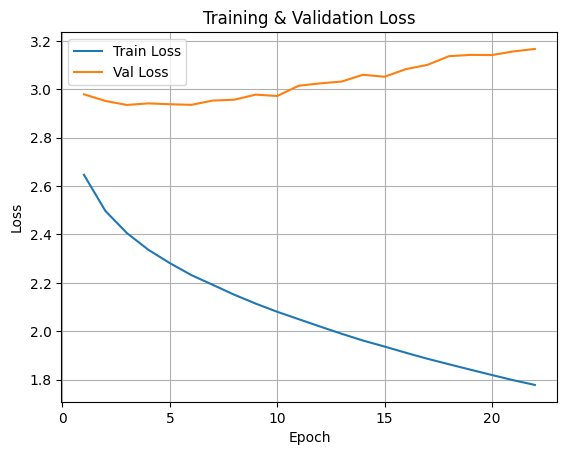

NameError: name 'ciders' is not defined

In [41]:
num_epochs_xe = 30
patience = 7
best_bleu4 = 0.0          # lưu theo BLEU-4
save_path_xe = "captioner_rsicd_xe.pt"
epochs_no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs_xe):
    train_loss = train_one_epoch_xe(model, train_loader, optimizer, criterion, device)
    val_loss, bleu4 = evaluate(model, val_loader, tokenizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs_xe}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    # CHỌN MODEL THEO BLEU-4
    if bleu4 > best_bleu4:
        best_bleu4 = bleu4
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bleu4': bleu4,
        }, save_path_xe)
        print(f"Saved best XE model (BLEU-4: {bleu4*100:.2f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

plot_loss_curve(train_losses, val_losses)


In [51]:
checkpoint = torch.load(save_path_xe, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded XE model from epoch {checkpoint['epoch']+1}, "
      f"BLEU-4: {checkpoint['bleu4']*100:.2f}")

# Lower learning rate for SCST
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 5e-6},
    {'params': decoder.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)

num_epochs_scst = 20
best_bleu4_scst = checkpoint['bleu4']      # theo dõi BLEU-4 tốt nhất trong SCST
save_path_scst = "captioner_rsicd_scst.pt"
epochs_no_improve = 0
bleu4s = []
for epoch in range(num_epochs_scst):
    train_loss, avg_reward = train_one_epoch_scst(
        model, train_loader, tokenizer, optimizer, device
    )
    val_loss, bleu4 = evaluate(model, val_loader, tokenizer, device)
    bleu4s.append(bleu4)
    print(f"Epoch {epoch+1}/{num_epochs_scst}")
    print(f"  Train Loss: {train_loss:.4f}, Avg Reward: {avg_reward:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}")

    # CHỌN MODEL THEO BLEU-4
    if bleu4 > best_bleu4_scst:
        best_bleu4_scst = bleu4
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bleu4': bleu4,
        }, save_path_scst)
        print(f"  Saved best SCST model (BLEU-4: {bleu4*100:.2f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 5 and epoch >= 14:  # Shorter patience for SCST
            print("Early stopping triggered")
            break

print("\n" + "="*70)
print("Training completed!")

Loaded XE model from epoch 15, BLEU-4: 41.18


{'testlen': 11258, 'reflen': 10759, 'guess': [11258, 10164, 9070, 7976], 'correct': [7976, 4679, 3031, 2008]}
ratio: 1.0463797750719355
Epoch 1/20
  Train Loss: -5.2508, Avg Reward: -1.5288
  Val Loss: 3.2649, BLEU-4: 40.70


{'testlen': 10789, 'reflen': 10574, 'guess': [10789, 9695, 8601, 7507], 'correct': [7975, 4874, 3160, 2090]}
ratio: 1.0203328919991468
Epoch 2/20
  Train Loss: -0.5776, Avg Reward: -0.6165
  Val Loss: 3.6363, BLEU-4: 44.15
  Saved best SCST model (BLEU-4: 44.15


{'testlen': 11350, 'reflen': 10891, 'guess': [11350, 10256, 9162, 8068], 'correct': [8138, 5093, 3356, 2199]}
ratio: 1.0421448902762793
Epoch 3/20
  Train Loss: -0.2186, Avg Reward: -0.3676
  Val Loss: 3.9339, BLEU-4: 43.42


{'testlen': 11469, 'reflen': 10880, 'guess': [11469, 10375, 9281, 8187], 'correct': [8299, 5082, 3311, 2179]}
ratio: 1.0541360294116677
Epoch 4/20
  Train Loss: -0.1426, Avg Reward: -0.2726
  Val Loss: 4.1771, BLEU-4: 42.83


{'testlen': 11490, 'reflen': 10949, 'guess': [11490, 10396, 9302, 8208], 'correct': [8161, 4956, 3184, 2028]}
ratio: 1.0494109051053933
Epoch 5/20
  Train Loss: -0.1174, Avg Reward: -0.2247
  Val Loss: 4.2029, BLEU-4: 41.14


{'testlen': 11287, 'reflen': 10925, 'guess': [11287, 10193, 9099, 8005], 'correct': [8268, 5044, 3274, 2073]}
ratio: 1.033135011441553
Epoch 6/20
  Train Loss: -0.1004, Avg Reward: -0.2061
  Val Loss: 4.2038, BLEU-4: 42.87


{'testlen': 10866, 'reflen': 10647, 'guess': [10866, 9772, 8678, 7584], 'correct': [8354, 5217, 3392, 2151]}
ratio: 1.0205691744152323
Epoch 7/20
  Train Loss: -0.0703, Avg Reward: -0.1722
  Val Loss: 4.3068, BLEU-4: 46.19
  Saved best SCST model (BLEU-4: 46.19


{'testlen': 11149, 'reflen': 10807, 'guess': [11149, 10055, 8961, 7867], 'correct': [8453, 5276, 3427, 2222]}
ratio: 1.031646155269637
Epoch 8/20
  Train Loss: -0.0616, Avg Reward: -0.1665
  Val Loss: 4.5263, BLEU-4: 45.53


{'testlen': 11332, 'reflen': 10938, 'guess': [11332, 10238, 9144, 8050], 'correct': [8541, 5368, 3491, 2195]}
ratio: 1.0360212104588558
Epoch 9/20
  Train Loss: -0.0555, Avg Reward: -0.1432
  Val Loss: 4.4447, BLEU-4: 45.04


{'testlen': 11568, 'reflen': 10957, 'guess': [11568, 10474, 9380, 8286], 'correct': [8579, 5325, 3479, 2246]}
ratio: 1.055763438897412
Epoch 10/20
  Train Loss: -0.0587, Avg Reward: -0.1356
  Val Loss: 4.5521, BLEU-4: 44.12


{'testlen': 11174, 'reflen': 10824, 'guess': [11174, 10080, 8986, 7892], 'correct': [8450, 5360, 3536, 2279]}
ratio: 1.0323355506281382
Epoch 11/20
  Train Loss: -0.0507, Avg Reward: -0.1245
  Val Loss: 4.7548, BLEU-4: 46.23
  Saved best SCST model (BLEU-4: 46.23


{'testlen': 11618, 'reflen': 11109, 'guess': [11618, 10524, 9430, 8336], 'correct': [8478, 5330, 3449, 2176]}
ratio: 1.0458187055539612
Epoch 12/20
  Train Loss: -0.0414, Avg Reward: -0.1120
  Val Loss: 4.7008, BLEU-4: 43.34


{'testlen': 12675, 'reflen': 11160, 'guess': [12675, 11581, 10487, 9393], 'correct': [8329, 5162, 3286, 2070]}
ratio: 1.1357526881719413
Epoch 13/20
  Train Loss: -0.0438, Avg Reward: -0.1270
  Val Loss: 5.0100, BLEU-4: 37.71


{'testlen': 10978, 'reflen': 10744, 'guess': [10978, 9884, 8790, 7696], 'correct': [8248, 5147, 3333, 2111]}
ratio: 1.0217795979150204
Epoch 14/20
  Train Loss: -0.0460, Avg Reward: -0.1110
  Val Loss: 4.9346, BLEU-4: 44.91


{'testlen': 11576, 'reflen': 11086, 'guess': [11576, 10482, 9388, 8294], 'correct': [8756, 5500, 3604, 2285]}
ratio: 1.0441998917552728
Epoch 15/20
  Train Loss: -0.0387, Avg Reward: -0.1116
  Val Loss: 4.8144, BLEU-4: 45.26


{'testlen': 11116, 'reflen': 10817, 'guess': [11116, 10022, 8928, 7834], 'correct': [8413, 5346, 3491, 2220]}
ratio: 1.0276416751408868
Epoch 16/20
  Train Loss: -0.0289, Avg Reward: -0.0966
  Val Loss: 4.9716, BLEU-4: 45.99
Early stopping triggered

Training completed!


NameError: name 'best_cider' is not defined

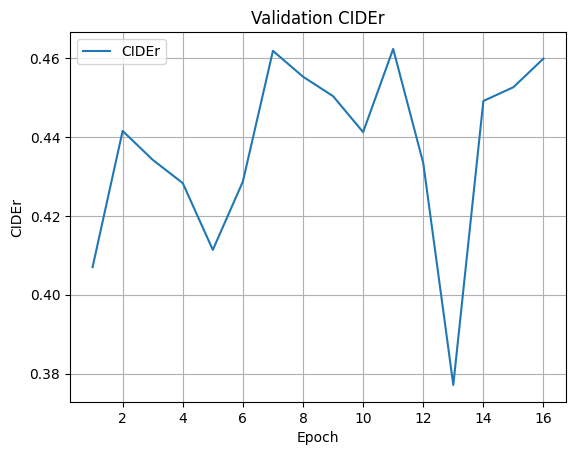

In [52]:
plot_cider_curve(bleu4s)


In [54]:
checkpoint = torch.load(save_path_scst, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best SCST model from epoch {checkpoint['epoch']+1}")
print(f"  - Validation BLEU-4: {checkpoint['bleu4']*100:.2f}\n")

test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*70)
print("TEST RESULTS:")
print("="*70)
print(f"Number of test samples: {test_results['num_samples']}")
print(f"Loss: {test_results['loss']:.4f}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")
if test_results['SPICE'] is not None:
    print(f"  SPICE:   {test_results['SPICE']*100:6.2f}")

Loaded best SCST model from epoch 11
  - Validation BLEU-4: 46.23

Generating captions for test set...


Test: 100%|██████████| 35/35 [01:39<00:00,  2.85s/it]



Computing metrics...
  - Computing BLEU scores...
{'testlen': 11107, 'reflen': 11602, 'guess': [11107, 10014, 8921, 7828], 'correct': [7014, 3103, 1581, 842]}
ratio: 0.9573349422512534
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...
  - Computing SPICE...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classif

SPICE evaluation took: 2.560 min

TEST RESULTS:
Number of test samples: 1093
Loss: 5.7743

Scores:
  BLEU-1:   60.40
  BLEU-2:   42.31
  BLEU-3:   31.19
  BLEU-4:   23.64
  METEOR:   26.94
  ROUGE-L:  44.86
  CIDEr:   0.5688
  SPICE:    24.94



Visualizing random examples...

Saved visualization to 'test_predictions.png'


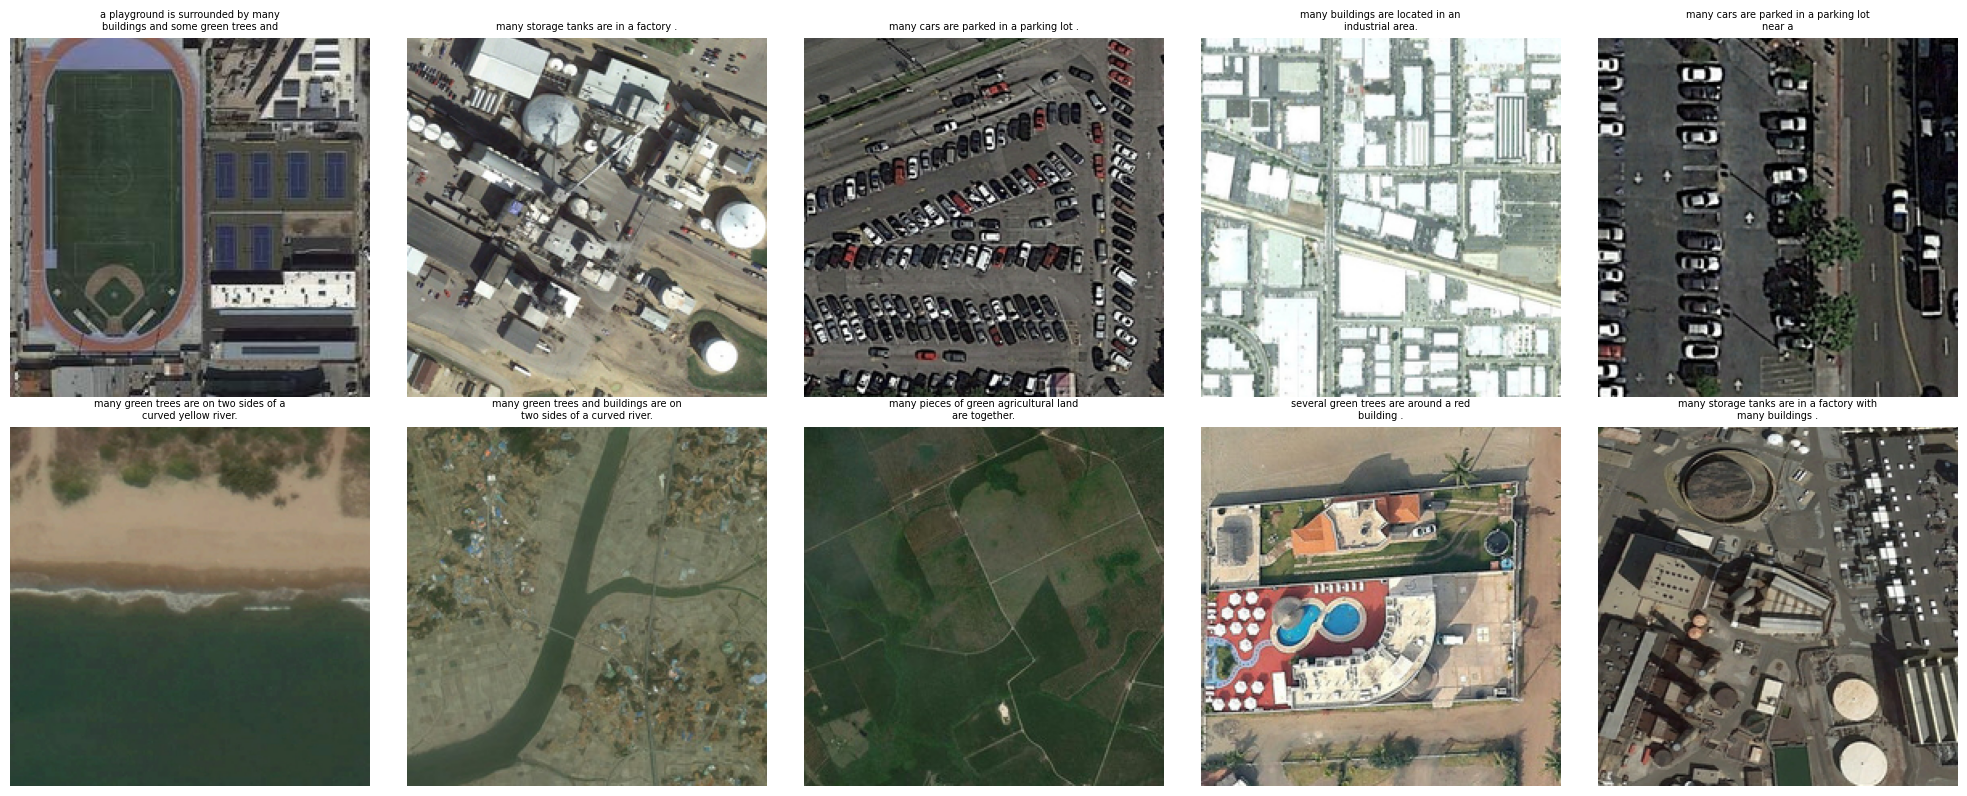

In [55]:
import matplotlib.pyplot as plt
import textwrap
import json

def visualize_predictions(refs, hyps, dataset, num_examples=10):
    indices = random.sample(range(len(refs)), min(num_examples, len(refs)))

    cols = 5
    rows = (num_examples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if num_examples > 1 else [axes]

    for ax_idx, img_idx in enumerate(indices):
        ex = dataset.data[img_idx]
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        axes[ax_idx].imshow(image)
        axes[ax_idx].axis('off')

        pred = hyps[img_idx][0]
        wrapped_pred = textwrap.fill(pred, width=40)
        axes[ax_idx].set_title(wrapped_pred, fontsize=7)

    for ax_idx in range(num_examples, len(axes)):
        axes[ax_idx].axis('off')

    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
    print("\nSaved visualization to 'test_predictions.png'")
    plt.show()

print("\nVisualizing random examples...")
visualize_predictions(test_refs, test_hyps, test_data, num_examples=10)


In [ ]:
output_file = 'test_predictions.json'
predictions = []
for idx in range(len(test_refs)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if v is not None else None for k, v in test_results.items()},
        'predictions': predictions[:100]
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")